In [124]:
import pandas as pd
import numpy as np
import grid as grid
import rasterio as raster
import gdal as gd
import geopandas as gpd
import matplotlib as plt
from scipy import misc
import rtree
import shapefile as shp
import pyproj
import geopy
import geoplotlib
import missingno as msno
import pandas_summary

%matplotlib inline

In [68]:
from zipfile import ZipFile
file_list=['data.zip']

In [72]:
for archive in file_list:
    zfile=ZipFile(archive)
    zfile.extractall('data')

In [22]:
#data import
shapefile='Parcels2014Hennepin.dbf'
hennepin=gpd.read_file(shapefile)

In [8]:
##Optional
#change cell width
from IPython.core.display import display,HTML
display(HTML("<style>.container {width:100% !important; },/<style>"))

#show all columns
pd.options.display.max_columns=None

# no sci notation
pd.set_option('display.float_format', lambda x: '%.3f'%x)

#plot sizes
plt.rcParams["figure.figsize"]=10,10

In [23]:
# get the info
hennepin.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 427762 entries, 0 to 427761
Data columns (total 70 columns):
Shape_Leng    427762 non-null float64
COUNTY_ID     427762 non-null object
PIN           427762 non-null object
BLDG_NUM      427762 non-null object
PREFIX_DIR    0 non-null object
PREFIXTYPE    0 non-null object
STREETNAME    427762 non-null object
STREETTYPE    0 non-null object
SUFFIX_DIR    0 non-null object
UNIT_INFO     51470 non-null object
CITY          427762 non-null object
CITY_USPS     414475 non-null object
ZIP           427762 non-null object
ZIP4          0 non-null object
PLAT_NAME     426333 non-null object
BLOCK         305269 non-null object
LOT           290705 non-null object
ACRES_POLY    427762 non-null float64
ACRES_DEED    427762 non-null float64
USE1_DESC     426337 non-null object
USE2_DESC     4398 non-null object
USE3_DESC     752 non-null object
USE4_DESC     207 non-null object
MULTI_USES    0 non-null object
LANDMARK      0 non-null obje

# Exploring Data

In [24]:
#Check uniqueness of column before setting it as a index
hennepin['PIN'].nunique(dropna=True)/len(hennepin['PIN'])
#set index and sort to make processing fast
hennepin=hennepin.set_index(['PIN']).sort_index()

In [25]:
def convert_to_categorical(df,cols):
    for col in cols:
        unique_vals=len(df[col].unique())
        
        unique_ratio=unique_vals/len(df)
        if unique_ratio<=0.2:
            df[col]=df[col].astype('category')
    return df

In [26]:
column_list=list(hennepin.select_dtypes(include=['object']).columns.values)
len(column_list)
#remove value in column list which we dont want to convert to categorical
column_list.remove('geometry')

In [27]:
hennepin=convert_to_categorical(hennepin,column_list)

In [28]:
hennepin.info(verbose=False)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 427762 entries, 053-0102724110003 to 053-3612123410019
Columns: 69 entries, Shape_Leng to geometry
dtypes: category(50), float64(13), int64(2), object(4)
memory usage: 96.1+ MB


In [15]:
type(hennepin)

geopandas.geodataframe.GeoDataFrame

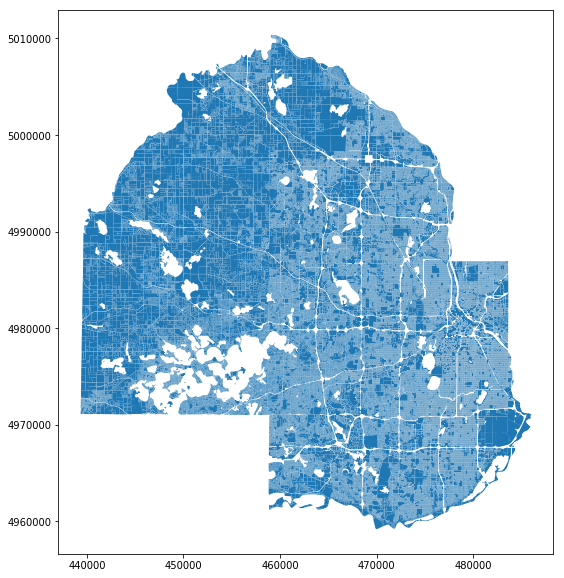

In [16]:
hennepin.plot()

In [29]:
from pandas_summary import DataFrameSummary

In [30]:
hennepin_stats=DataFrameSummary(hennepin.drop('geometry',axis=1))

In [76]:
#to create random index
#m['id'] = [random.randint(0,1000) for x in range(m.shape[0])]

In [123]:
#to list columns with missing records drop them from the analysis

ans=[]
for i in range(len(m.index)):
    if m.values[i]==float(1):
        ans.append(m.index[i])
hennepin=hennepin.drop(ans,axis=1)

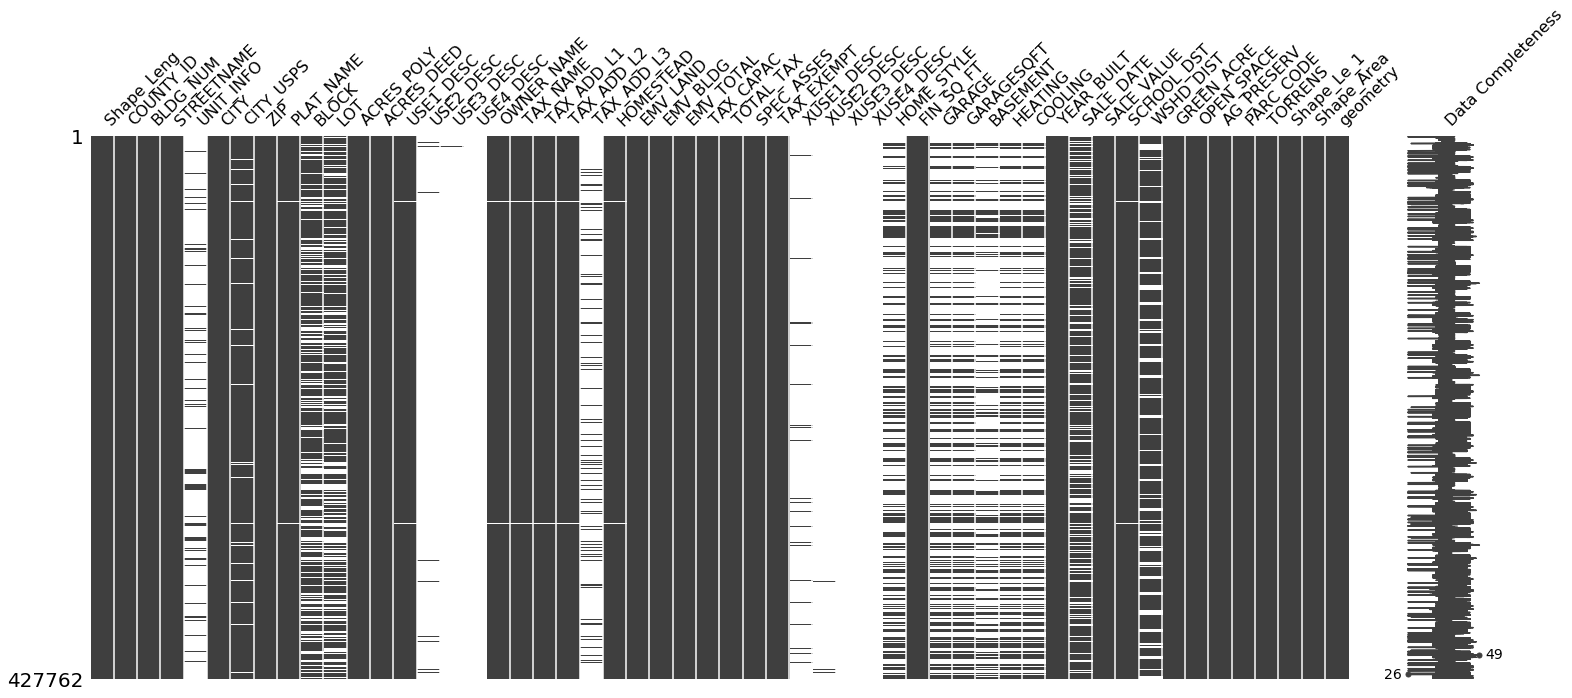

In [129]:
#Finds missingness in the data 
msno.matrix(hennepin,labels=True, sort=True)

In [137]:
def delete_near_null(df,cols,populated_threshold=0.01):
    for col in cols:
        non_null_rows =df[col].count()
        total_rows=len(df[col])
        populated_ratio=non_null_rows/total_rows
        if populated_ratio<=populated_threshold:
            del df[col]
    return df

In [146]:
# Get the full list of columns to check
column_list=list(hennepin.columns.values)

#Dont want to edit geometry colum
column_list.remove('geometry')

hennepin=delete_near_null(hennepin,column_list)

In [148]:
hennepin.shape

(427762, 49)

In [152]:
#Filterning on Geodesic Features
hennepin=hennepin[hennepin['geometry'].geom_type!='Point']